In [1863]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
import ipaddress
from scipy.stats import truncnorm
from collections import defaultdict

In [510]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [4]:
os.chdir("..")

In [5]:
accounts = pd.read_csv("./data/cleaned_data/account_df_clean.csv")
clients = pd.read_csv("./data/cleaned_data/client_df_clean.csv")
disp = pd.read_csv("./data/cleaned_data/disposition_df_clean.csv")
card = pd.read_csv("./data/cleaned_data/card_df_clean.csv")
district = pd.read_csv("./data/cleaned_data/district_df_clean.csv")
loan = pd.read_csv("./data/cleaned_data/loan_df_clean.csv")

In [6]:
trans = pd.read_csv("./data/cleaned_data/transaction_df_clean.csv", dtype={8:"str"})

In [7]:
print(district.shape)
district.head(1)

(77, 16)


,district_code,district_name,region,population,no_of_mun_below_500,no_of_mun_between_500_1999,no_of_mun_between_2000_9999,no_of_mun_above_10000,no_of_cities,ratio_of_urban_population,avg_salary,unemployment_rate_95,unemployment_rate_96,enterpreneurs_per_1000,crimes_num_95,crimes_num_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.000000,12541,0.290000,0.430000,167,85677.000000,99107


In [8]:
district_short = district[["district_code","district_name", "region", "population"]].sort_values("population", ascending=False).reset_index(drop=True)
district_short.head()

,district_code,district_name,region,population
0,1,Hl.m. Praha,Prague,1204953
1,54,Brno - mesto,south Moravia,387570
2,74,Ostrava - mesto,north Moravia,323870
3,70,Karvina,north Moravia,285387
4,68,Frydek - Mistek,north Moravia,228848


In [9]:
# посчитаем клиентов по районам. Это нужно для дальнейшей замены чешских районов

clieints_by_dist = clients.groupby("district_id", as_index=False).agg({"client_id":"count"}) \
                        .rename(columns={"client_id":"clients"})

In [10]:
# соединим district_short и clieints_by_dist чтобы отсортировать районы по количеству клиентов в дальнейшем

district_short = district_short.merge(clieints_by_dist, left_on="district_code", right_on="district_id")
print(district_short.shape)
district_short.head()

(77, 6)


,district_code,district_name,region,population,district_id,clients
0,1,Hl.m. Praha,Prague,1204953,1,663
1,54,Brno - mesto,south Moravia,387570,54,155
2,74,Ostrava - mesto,north Moravia,323870,74,180
3,70,Karvina,north Moravia,285387,70,169
4,68,Frydek - Mistek,north Moravia,228848,68,86


# Замена чешских районов на Российские города
С целью чтобы упростить в дальнейшем процесс реалистичной генерации координат транзакций клиентов, я решил заменить чешские районы на российские города.
Далее мы проверим насколько схожи профиля городов России и районов Чехии. Но сильное сходство нам не нужно

In [11]:
# список российских городов с населением и другой информацией

russian_cities_list = "https://gist.githubusercontent.com/dnovik/694d106be3ff20eb0c73a0511c83b7f3/raw/056b7ece3b762723c02d3809ef77e2ae92a2bcd0/cities.csv"

In [12]:
russian_cities = pd.read_csv(russian_cities_list)

In [13]:
russian_cities.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.000000,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,ccdfd496-8108-4655-aadd-bd228747306d,4: город,0,79403000000,79703000001.000000,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.000000,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,8cfbe842-e803-49ca-9347-1ef90481dd98,4: город,2,79401000000,79701000001.000000,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.000000,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,0839d751-b940-4d3d-afb6-5df03fdd7791,4: город,2,84401000000,84701000.000000,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.000000,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,ae716080-f27b-40b6-a555-cf8b518e849e,4: город,0,1403000000,1703000.000000,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.000000,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,d13945a8-7017-46ab-b1e6-ede1e89317ad,4: город,2,1401000000,1701000.000000,2200,UTC+7,53.348115,83.779836,Сибирский,635585


In [14]:
# создадим маппинг для переименования колонок

ru_cities_col_mapping = {"Регион":"region", "Город":"area", "Часовой пояс":"timezone", "Широта":"lat", "Долгота":"lon", "Население":"population_ru"}

In [15]:
# russian_cities.columns

In [16]:
# переименуем нужные нам колонки и оставим только их. Население приведем к типу int

ru_cities_short = russian_cities.rename(columns=ru_cities_col_mapping).loc[:, ru_cities_col_mapping.values()].copy()

In [17]:
ru_cities_short.dtypes

region            object
area              object
timezone          object
lat              float64
lon              float64
population_ru     object
dtype: object

In [18]:
# проверим на значения в population где кроме чисел есть что-то еще
# отфильтруем по булевой маске: сперва создадим массив с булевыми значениями,
# где True это совпадение с regex - у нас regex проверяет является ли строка числом с количеством цифр от 1 до 8
# через тильду ~ мы инвертируем этот массив. И у нас теперь True это все строки где кроме цельного числа есть что-то еще в строке
# ^ начало строки. $ конец строки. \d{1,8} это значит "числа, от 1 до 8 чисел подряд"

dirty_records = ru_cities_short[~ru_cities_short.population_ru.str.match(r"^\d{1,8}$")].population_ru
dirty_records

923    96[3]
Name: population_ru, dtype: object

In [19]:
# создадим дубликат колонки для дальнейших изменений в ней. Чтобы можно было коротко сверить что значения для остальных записей
# остались прежними

ru_cities_short.loc[:, "popul_ru_clean"] = ru_cities_short.loc[:, "population_ru"]

In [20]:
# извлечем чистые числа из грязных значений. Отфильтруем по индексу для изменения и вставки значений
# сделаем этом кусок кода масштабируемым на случай если у нас изменятся исходные данные - прибавятся новые и т.п.

ru_cities_short.loc[dirty_records.index, "popul_ru_clean"] = ru_cities_short.loc[dirty_records.index, "population_ru"] \
                                                                .str.findall(r"\d{1,8}").str[0]

In [21]:
ru_cities_short.head()

,region,area,timezone,lat,lon,population_ru,popul_ru_clean
0,Адыгея,Адыгейск,UTC+3,44.878372,39.190172,12689,12689
1,Адыгея,Майкоп,UTC+3,44.609827,40.100653,144055,144055
2,Алтай,Горно-Алтайск,UTC+7,51.958268,85.960296,62861,62861
3,Алтайский,Алейск,UTC+7,52.492091,82.779415,28528,28528
4,Алтайский,Барнаул,UTC+7,53.348115,83.779836,635585,635585


In [22]:
ru_cities_short.tail()

,region,area,timezone,lat,lon,population_ru,popul_ru_clean
1107,Ярославская,Ростов,UTC+3,57.205018,39.437836,31791,31791
1108,Ярославская,Рыбинск,UTC+3,58.048380,38.858338,200771,200771
1109,Ярославская,Тутаев,UTC+3,57.867424,39.536823,41001,41001
1110,Ярославская,Углич,UTC+3,57.522387,38.301979,34505,34505
1111,Ярославская,Ярославль,UTC+3,57.621614,39.897878,591486,591486


In [23]:
ru_cities_short.loc[dirty_records.index]

,region,area,timezone,lat,lon,population_ru,popul_ru_clean
923,Татарстан,Иннополис,UTC+3,55.752154,48.744616,96[3],96


In [24]:
# удалим колонку population_ru со старыми значениями

ru_cities_short.drop(columns="population_ru", inplace=True)

In [25]:
ru_cities_short.head(1)

,region,area,timezone,lat,lon,popul_ru_clean
0,Адыгея,Адыгейск,UTC+3,44.878372,39.190172,12689


In [26]:
# приведем значения в колонке к int

ru_cities_short["popul_ru_clean"] = ru_cities_short.loc[:, "popul_ru_clean"].astype("int")

In [27]:
ru_cities_short

,region,area,timezone,lat,lon,popul_ru_clean
0,Адыгея,Адыгейск,UTC+3,44.878372,39.190172,12689
1,Адыгея,Майкоп,UTC+3,44.609827,40.100653,144055
2,Алтай,Горно-Алтайск,UTC+7,51.958268,85.960296,62861
3,Алтайский,Алейск,UTC+7,52.492091,82.779415,28528
4,Алтайский,Барнаул,UTC+7,53.348115,83.779836,635585
...,...,...,...,...,...,...
1107,Ярославская,Ростов,UTC+3,57.205018,39.437836,31791
1108,Ярославская,Рыбинск,UTC+3,58.048380,38.858338,200771
1109,Ярославская,Тутаев,UTC+3,57.867424,39.536823,41001
1110,Ярославская,Углич,UTC+3,57.522387,38.301979,34505


In [28]:
ru_cities_short.dtypes

region             object
area               object
timezone           object
lat               float64
lon               float64
popul_ru_clean      int64
dtype: object

In [520]:
# Проверим на пустые значения

nan_area = ru_cities_short[ru_cities_short.isna().any(axis=1)]
nan_area

,region,area,timezone,lat,lon,popul_ru_clean
506,Москва,NaN,UTC+3,55.753879,37.620373,11514330
782,Санкт-Петербург,NaN,UTC+3,59.939125,30.315822,4848742
863,Севастополь,NaN,UTC+3,44.616733,33.525355,344479


In [515]:
ru_cities_short.loc[ru_cities_short.popul_ru_clean == 49071].iloc[0,-2]

np.float64(45.5406838)

In [518]:
ru_cities_short.loc[ru_cities_short.popul_ru_clean == 49071].iloc[0,-3]

np.float64(43.1276072)

In [519]:
# город из Чеченской республики узнаем по координатам и заполним вручную. Остальные названия возьмем из region

ru_cities_short.loc[(ru_cities_short.lat == 43.1276072) & (ru_cities_short.lon == 45.5406838), "area"] = "Урус-Мартан"

In [521]:
# заполняем остальное

ru_cities_short["area"] = ru_cities_short["area"].fillna(ru_cities_short["region"])

In [522]:
# проверим результат

ru_cities_short.loc[(ru_cities_short.lat.isin(nan_area.lat)) & (ru_cities_short.lon.isin(nan_area.lon))]

,region,area,timezone,lat,lon,popul_ru_clean
506,Москва,Москва,UTC+3,55.753879,37.620373,11514330
782,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742
863,Севастополь,Севастополь,UTC+3,44.616733,33.525355,344479


In [29]:
# количество чешских районов в data berka 

district_short.shape[0]

77

In [30]:
# значит нужно 77 первых по населению городов РФ

ru_77_cities = ru_cities_short.sort_values("popul_ru_clean", ascending=False).copy().reset_index(drop=True).loc[0:76]

In [31]:
# первые 5 и последние 5 записей урезанного до 77 городов датафрейма

ru_77_cities.iloc[np.r_[0:5,-5:0]]

,region,area,timezone,lat,lon,popul_ru_clean
0,Москва,NaN,UTC+3,55.753879,37.620373,11514330
1,Санкт-Петербург,NaN,UTC+3,59.939125,30.315822,4848742
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921
3,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738
4,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615
72,Карелия,Петрозаводск,UTC+3,61.789090,34.359626,263540
73,Ростовская,Таганрог,UTC+3,47.209491,38.935154,257692
74,Ханты-Мансийский Автономный округ - Югра,Нижневартовск,UTC+5,60.939738,76.569621,251860
75,Марий Эл,Йошкар-Ола,UTC+3,56.634376,47.899845,248688
76,Иркутская,Братск,UTC+8,56.151395,101.633989,246348


In [526]:
# ru_77_cities.isna().sum()

In [527]:
# ru_77_cities[ru_77_cities.area.isna()]

In [524]:
# ru_77_cities["area"] = ru_77_cities["area"].fillna(ru_77_cities["region"])

In [528]:
# ru_77_cities.isna().sum()

In [529]:
ru_77_cities.head()

,region,area,timezone,lat,lon,popul_ru_clean
0,Москва,Москва,UTC+3,55.753879,37.620373,11514330
1,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742
2,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921
3,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738
4,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615


In [37]:
# количество записей

ru_77_cities.shape

(77, 6)

# Сравнения профилей численности населения чешских районов и российских городов
## Насколько подходит замена чешских районов на российские города?

### Сравним коэффиценты изменчивости численности населения для чешских районов и для российских городов

Формула коэффициента: cv = standard deviation / mean * 100

In [38]:
cz_mean_pop = district_short.population.mean()
cz_pop_std = district_short.population.std()
czech_cv = cz_pop_std / cz_mean_pop * 100


print(f"""Czech variability coefficient: {czech_cv:.2f}%""")

Czech variability coefficient: 102.26%


In [39]:
ru_mean_pop = ru_77_cities.popul_ru_clean.mean()
ru_pop_std = ru_77_cities.popul_ru_clean.std()

ru_cv = ru_pop_std / ru_mean_pop * 100

print(f"""Russian variability coefficient: {ru_cv:.2f}%""")

Russian variability coefficient: 183.48%


In [40]:
# во сколько раз российский коэффициент изменчивости больше чешского

print(f"""Russian population cv is {ru_cv / czech_cv:.2f} times higher than czech cv""")

Russian population cv is 1.79 times higher than czech cv


### Вывод по коэффициентам изменчивости
В России отклонение от среднего почти в два раза больше чем Чехии

#### Сравним процент населения от столицы в Чехии и России

In [41]:
czech_pop_perc_from_max = district_short.population.div(district_short.population.max()).mul(100).round(2)

In [42]:
ru_pop_perc_from_max = ru_77_cities.popul_ru_clean.div(ru_77_cities.popul_ru_clean.max()).mul(100).round(2)

In [43]:
pop_perc_from_capital = pd.concat([czech_pop_perc_from_max, ru_pop_perc_from_max], axis=1) \
                                .rename(columns={"population":"pop_perc_cz","popul_ru_clean":"pop_perc_ru"}) \
                                .query("pop_perc_cz < 100 and pop_perc_ru < 100")
pop_perc_from_capital.head()

,pop_perc_cz,pop_perc_ru
1,32.160000,42.110000
2,26.880000,13.020000
3,23.680000,11.970000
4,18.990000,10.860000
5,18.770000,10.570000


#### Посмотрим на графике

''

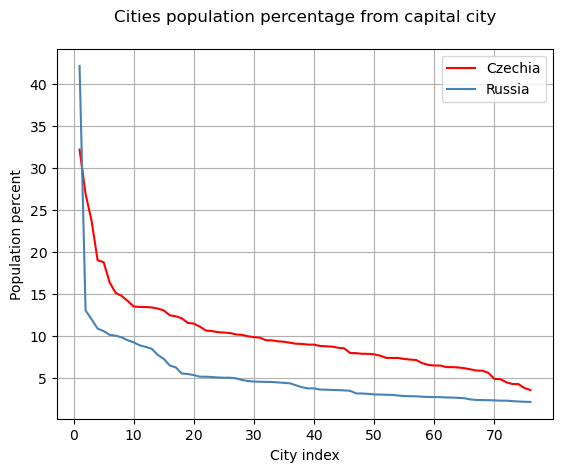

In [44]:
fig, ax = plt.subplots()

sns.lineplot(data=pop_perc_from_capital, x=pop_perc_from_capital.index, y="pop_perc_cz", label="Czechia", color="red", ax=ax)
sns.lineplot(data=pop_perc_from_capital, x=pop_perc_from_capital.index, y="pop_perc_ru", label="Russia", color="steelblue", ax=ax)
ax.grid(which="both")
ax.set_title("Cities population percentage from capital city", pad=20)
ax.set_xlabel("City index")
ax.set_ylabel("Population percent")

;

### Вывод по проценту населения относительно столицы
В России он меньше, кроме первого города в сравнении - С.Петербурга<br>
Но динамика в целом схожа. Так что остановимся на выборе российских городов для замены в датасете.


# Замена чешских районов на российские города

In [45]:
district_ru = ru_77_cities.copy()

In [46]:
# отсортируем district_short по количеству клиентов в районе, по убыванию. 
# Чтобы у нас в дальнейшей замене динамика населения городов России совпадала с количеством клиентов в городах

district_short = district_short.sort_values("clients", ascending=False).reset_index(drop=True)
district_short.iloc[np.r_[0:5,-5:0]] # первые 5 и последние 5 записей

,district_code,district_name,region,population,district_id,clients
0,1,Hl.m. Praha,Prague,1204953,1,663
1,74,Ostrava - mesto,north Moravia,323870,74,180
2,70,Karvina,north Moravia,285387,70,169
3,54,Brno - mesto,south Moravia,387570,54,155
4,64,Zlin,south Moravia,197099,64,109
72,12,Pribram,central Bohemia,107870,12,44
73,65,Znojmo,south Moravia,114200,65,44
74,58,Jihlava,south Moravia,109164,58,44
75,24,Karlovy Vary,west Bohemia,122603,24,43
76,20,Strakonice,south Bohemia,70646,20,43


In [47]:
# district_ru.drop(columns=["district_code","clients"] , inplace=True)

In [48]:
# просто берем отсортированные по количеству клиентов коды районов и добавляем в датафрейм с российскими городами

district_ru["district_code"] = district_short.district_code

In [49]:
# количество колонок в district_ru
district_ru_col_number = district_ru.shape[1]

In [50]:
# переставим добавленную колонку district_code в начало
# для этого создадим список с желаемыми позициями колонок. последняя позиция + список позиций с 0 до предпоследней
dist_cols_reorder = [-1] + list(range(district_ru.shape[1] - 1))
district_ru = district_ru.iloc[:,dist_cols_reorder].copy()

In [51]:
# Сверим количество колонок после перестановки

if district_ru_col_number > district_ru.shape[1]:
    raise ValueError(f"""Initial cols number is bigger than current cols number for district_ru:
Initial cols shape: {district_ru_col_number}
Current cols shape: {district_ru.shape[1]}""")

elif district_ru_col_number < district_ru.shape[1]:
    raise ValueError(f"""Initial cols number is less than current cols number for district_ru:
Initial cols shape: {district_ru_col_number}
Current cols shape: {district_ru.shape[1]}""")  

else:
    print(f"""Initial cols and current cols number are identical:
Initial cols shape: {district_ru_col_number}
Current cols shape: {district_ru.shape[1]}""") 
    

Initial cols and current cols number are identical:
Initial cols shape: 7
Current cols shape: 7


In [55]:
# добавим также количество клиентов.

district_ru["clients"] = district_short.clients

In [53]:
# переименуем popul_ru_clean

district_ru = district_ru.rename(columns={"popul_ru_clean":"population"})

In [56]:
district_ru.iloc[np.r_[0:5, -5:0]] # первые 5 и последние 5 записей

,district_code,region,area,timezone,lat,lon,population,clients
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663
1,74,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,180
2,70,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,169
3,54,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738,155
4,64,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615,109
72,12,Карелия,Петрозаводск,UTC+3,61.789090,34.359626,263540,44
73,65,Ростовская,Таганрог,UTC+3,47.209491,38.935154,257692,44
74,58,Ханты-Мансийский Автономный округ - Югра,Нижневартовск,UTC+5,60.939738,76.569621,251860,44
75,24,Марий Эл,Йошкар-Ола,UTC+3,56.634376,47.899845,248688,43
76,20,Иркутская,Братск,UTC+8,56.151395,101.633989,246348,43


In [57]:
# проверим форму district_ru после всех изменений

district_ru.shape

(77, 8)

In [147]:
# os.chdir(r"C:\Users\iaros\My_documents\Education\projects\fraud_detection_01")

In [145]:
# dir = r"C:\Users\iaros\My_documents\Education\projects\fraud_detection_01\data\raw_data\geo\\"
# os.chdir(dir)
# files_1 = os.listdir(dir)
# i = 1

# for file in files_1:
#     new_name = "0" + str(i) + re.search(r"\D+", file).group()
#     os.rename(file, new_name)
#     print(new_name)
#     i += 1
    

# Работа с сырыми геоданными

In [59]:
geo_files = os.listdir("./data/raw_data/geo/")
geo_files[:5]

['01_central_ru.cpg',
 '01_central_ru.dbf',
 '01_central_ru.prj',
 '01_central_ru.shp',
 '01_central_ru.shx']

In [60]:
[file for file in geo_files if re.match(r".+\.shp", file)]

['01_central_ru.shp',
 '02_crimea_ru.shp',
 '03_far_east_ru.shp',
 '04_caucasus_ru.shp',
 '05_northwest_ru.shp',
 '06_siberia_ru.shp',
 '07_south_ru.shp',
 '08_ural_ru.shp',
 '09_volga_ru.shp']

## Загрузка геоданных
города и их геополигоны (координаты границ)

In [61]:
ru_cities_tentative = pd.concat([gpd.read_file(f"./data/raw_data/geo/{file}") \
                       .query("fclass =='city' or fclass =='town'") for file in geo_files if re.match(r".+\.shp", file)], \
                     ignore_index=True)

In [62]:
# сузим данные, отфильтровав по именам городов из district_ru

ru_cities_tent_subset = ru_cities_tentative.loc[ru_cities_tentative.name.isin(district_ru.area)]


In [63]:
# проверка на одинаковые названия городов

ru_cities_tent_subset[ru_cities_tent_subset.duplicated("name", keep=False)]

,osm_id,code,fclass,population,name,geometry
300,3401282,1002,town,0,Киров,"POLYGON ((34.22729 54.09437, 34.23057 54.09479..."
2671,2383150,1001,city,521091,Киров,"MULTIPOLYGON (((49.34343 58.4958, 49.34606 58...."


In [64]:
# Удалим дубликаты. Ставим флаг keep='last', чтобы оставить последний из дубликатов

ru_cities_tent_subset = ru_cities_tent_subset.drop_duplicates(subset="name", keep='last')

ru_cities_tent_subset.head()

,osm_id,code,fclass,population,name,geometry
242,930950,1001,city,425000,Тверь,"MULTIPOLYGON (((35.72142 56.83594, 35.72156 56..."
315,3134925,1001,city,503216,Липецк,"MULTIPOLYGON (((39.37977 52.62677, 39.38317 52..."
388,389790,1001,city,401505,Иваново,"POLYGON ((40.86788 56.99265, 40.87023 56.99384..."
432,3348896,1001,city,449556,Курск,"POLYGON ((36.0603 51.67692, 36.06039 51.67947,..."
438,1991003,1001,city,352347,Владимир,"MULTIPOLYGON (((40.16496 56.12132, 40.16772 56..."


In [65]:
# проверим форму датафрейма

ru_cities_tent_subset.shape

(76, 6)

#### Не хватает одного города, должно быть 77. Проверим какого

In [66]:
# сделаем булеву маску и инвертируем ее значения.
# Покажет True для города, который не в ru_cities_tent_subset, но есть в district_ru

district_ru[~district_ru.area.isin(ru_cities_tent_subset.name)]

,district_code,region,area,timezone,lat,lon,population,clients
25,51,Дагестан,Махачкала,UTC+3,42.984857,47.504630,577990,61


In [67]:
# создадим вручную геополигон для Махачкалы на сайте https://geojson.io. B загрузим этот .geojson файл
# после соединения датафреймов, мы заполним недостающие данные для Махачкалы

makhachkala_poly = gpd.read_file("./data/raw_data/geo/makhachkala.geojson")
makhachkala_poly

,geometry
0,"POLYGON ((47.51911 42.90425, 47.53096 42.90538..."


<Axes: >

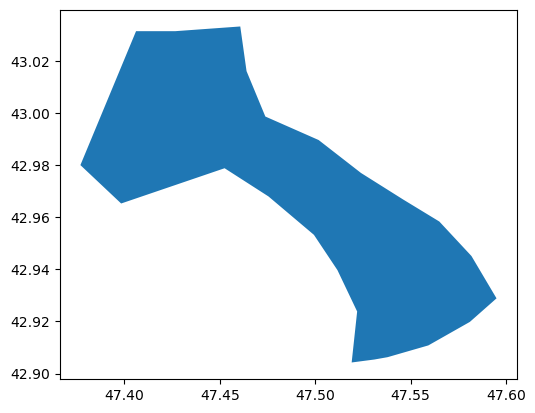

In [68]:
makhachkala_poly.plot() # график чтобы проверить, что полигон правильно загрузился

In [69]:
# сузим датафрейм с гео данными до двух колонок

ru_cities = ru_cities_tent_subset.loc[:, ["name", "geometry"]].copy().reset_index(drop=True)
ru_cities.head()

,name,geometry
0,Тверь,"MULTIPOLYGON (((35.72142 56.83594, 35.72156 56..."
1,Липецк,"MULTIPOLYGON (((39.37977 52.62677, 39.38317 52..."
2,Иваново,"POLYGON ((40.86788 56.99265, 40.87023 56.99384..."
3,Курск,"POLYGON ((36.0603 51.67692, 36.06039 51.67947,..."
4,Владимир,"MULTIPOLYGON (((40.16496 56.12132, 40.16772 56..."


## Соедининение district_ru и датафрейма с гео данными

In [70]:
district_ru_merge = district_ru.merge(ru_cities, how='left', left_on="area", right_on="name")
district_ru_merge.head()

,district_code,region,area,timezone,lat,lon,population,clients,name,geometry
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,Москва,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,74,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,180,Санкт-Петербург,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,70,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,169,Новосибирск,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."
3,54,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738,155,Екатеринбург,"POLYGON ((60.00708 56.80588, 60.01103 56.80777..."
4,64,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615,109,Нижний Новгород,"MULTIPOLYGON (((43.72068 56.21979, 43.7211 56...."


In [71]:
# проверка где не хватает значений после джоина

district_ru_merge[district_ru_merge.isna().any(axis=1)]

,district_code,region,area,timezone,lat,lon,population,clients,name,geometry
25,51,Дагестан,Махачкала,UTC+3,42.984857,47.504630,577990,61,NaN,None


In [72]:
# заполним данные о полигоне для Махачкалы

district_ru_merge.loc[district_ru_merge.area == "Махачкала", "geometry"] = makhachkala_poly.iloc[0,0]
district_ru_merge.loc[district_ru_merge.area == "Махачкала"]

,district_code,region,area,timezone,lat,lon,population,clients,name,geometry
25,51,Дагестан,Махачкала,UTC+3,42.984857,47.504630,577990,61,NaN,"POLYGON ((47.51911 42.90425, 47.53096 42.90538..."


In [73]:
# удалим колонку name. Она не нужна

district_ru_merge.drop(columns="name", inplace=True)

In [74]:
district_ru_merge.head()

,district_code,region,area,timezone,lat,lon,population,clients,geometry
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,74,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,180,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,70,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,169,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."
3,54,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738,155,"POLYGON ((60.00708 56.80588, 60.01103 56.80777..."
4,64,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615,109,"MULTIPOLYGON (((43.72068 56.21979, 43.7211 56...."


In [75]:
# проверим форму

district_ru_merge.shape

(77, 9)

In [76]:
# остались ли пустые значения

district_ru_merge.isna().sum()

district_code    0
region           0
area             0
timezone         0
lat              0
lon              0
population       0
clients          0
geometry         0
dtype: int64

# Генерация координат для транзакций

## Равномерное распределение

In [77]:
from shapely.geometry import Point, Polygon

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [78]:
nn_poly = district_ru_merge.query("area == 'Нижний Новгород'").iloc[0,-1]

In [79]:
gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[nn_poly])

In [80]:
x,y = Random_Points_in_Bounds(nn_poly, 500)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')

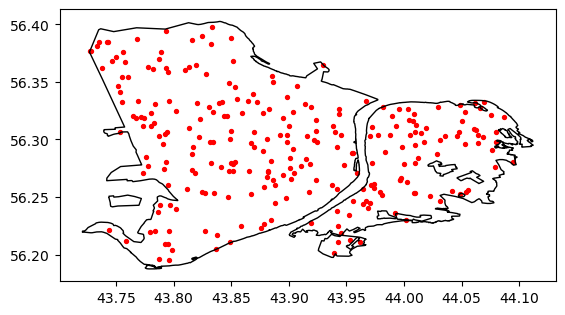

In [81]:
Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# Keep points in "myPoly"
pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# Plot result
base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()

In [82]:
district_ru_merge.head(1)

,district_code,region,area,timezone,lat,lon,population,clients,geometry
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."


In [83]:
clients.shape

(5369, 4)

In [116]:
# clients_with_geo = clients.merge(district_ru_merge, left_on="district_id", right_on="district_code")
# clients_with_geo.head()

In [117]:
# проверим форму

# clients_with_geo.shape

In [86]:
def gen_trans_coordinates(polygon, number):
    x,y = Random_Points_in_Bounds(polygon, number)
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='points')

    gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])
    
    Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

    # Оставить точки внутри "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

    return pnts_in_poly, gdf_poly
    

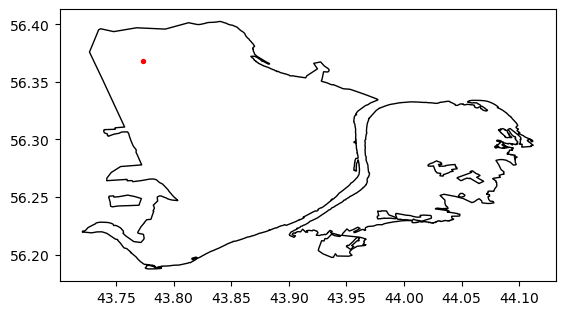

In [87]:
# Plot result
pnts_in_poly, gdf_poly = gen_trans_coordinates(nn_poly, 1)

base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()

In [118]:
# clients_with_geo.head()

In [119]:
# clients_with_geo[["area"]].value_counts()

In [120]:
district_ru_merge.head()

,district_code,region,area,timezone,lat,lon,population,clients,geometry
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
1,74,Санкт-Петербург,Санкт-Петербург,UTC+3,59.939125,30.315822,4848742,180,"POLYGON ((30.04334 59.76418, 30.04535 59.76553..."
2,70,Новосибирская,Новосибирск,UTC+7,55.028102,82.921058,1498921,169,"MULTIPOLYGON (((82.75113 54.99103, 82.75147 54..."
3,54,Свердловская,Екатеринбург,UTC+5,56.838633,60.605489,1377738,155,"POLYGON ((60.00708 56.80588, 60.01103 56.80777..."
4,64,Нижегородская,Нижний Новгород,UTC+3,56.324209,44.005395,1250615,109,"MULTIPOLYGON (((43.72068 56.21979, 43.7211 56...."


In [121]:
# загрузим датасет по антифроду для заимстования категорий товаров и их средних цен

fraud_kaggle = pd.read_csv(r"C:\Users\iaros\My_documents\Education\DBs_datasets\antifraud\cc_trans_fraud_detect_kaggle\fraudTest.csv.zip", \
                          compression="zip")

In [123]:
# fraud_kaggle.merchant.nunique()

693

In [136]:
# fraud_kaggle[['first', 'last', 'gender']].value_counts().reset_index().query("count > 200")

In [135]:
693 / 917 * 100 # merchants percent from customers in fraud_kaggle

75.57251908396947

In [180]:
# hours_dist = [round(np.random.normal(12, 4)) for i in range(10000)]
# hours_dist = [hour for hour in hours_dist if hour < 25 and hour > 0]

In [196]:
# p = sns.countplot(x=hours_dist);

In [199]:
fraud_kaggle.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.860,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986,-81.201,0


In [222]:
# ru_retail = pd.read_csv(r"C:\Users\iaros\My_documents\Education\Загрузки_учеба\russian_retail.csv.zip", compression="zip")

In [679]:
category_stats = fraud_kaggle.groupby("category").agg({"amt":["mean","std"], "category":"count"})
category_stats.columns = ["avg_amt", "amt_std", "cat_count"]
category_stats = category_stats.sort_values("cat_count",ascending=False).reset_index()
category_stats

,category,avg_amt,amt_std,cat_count
0,gas_transport,63.577001,15.828399,56370
1,grocery_pos,115.885327,51.552330,52553
2,home,57.995413,48.085281,52345
3,shopping_pos,76.862457,232.484678,49791
4,kids_pets,57.506913,48.748482,48692
5,shopping_net,83.481653,237.219758,41779
6,entertainment,63.984840,64.229935,40104
7,personal_care,48.233021,49.410941,39327
8,food_dining,50.777938,48.449053,39268
9,health_fitness,53.867432,47.965251,36674


In [238]:
offline_categories = category_stats[~category_stats.category.str.contains("net")].reset_index(drop=True)
offline_categories[["avg_amt","amt_std","cat_count"]] = offline_categories[["avg_amt","amt_std","cat_count"]] * 10
offline_categories

,category,avg_amt,amt_std,cat_count
0,gas_transport,635.770,158.284,563700
1,grocery_pos,1158.853,515.523,525530
2,home,579.954,480.853,523450
3,shopping_pos,768.625,2324.847,497910
4,kids_pets,575.069,487.485,486920
5,entertainment,639.848,642.299,401040
6,personal_care,482.330,494.109,393270
7,food_dining,507.779,484.491,392680
8,health_fitness,538.674,479.653,366740
9,misc_pos,621.822,1339.872,345740


In [239]:
online_categories = category_stats[category_stats.category.str.contains("net")].reset_index(drop=True)
online_categories[["avg_amt","amt_std","cat_count"]] = online_categories[["avg_amt","amt_std","cat_count"]] * 10
online_categories

,category,avg_amt,amt_std,cat_count
0,shopping_net,834.817,2372.198,417790
1,misc_net,786.002,1636.391,273670
2,grocery_net,537.317,229.084,194260


In [240]:

selling_points_prep = district_ru_merge.merge(offline_categories, how="cross").sort_values("population", ascending=False)
selling_points_prep

,district_code,region,area,timezone,lat,lon,population,clients,geometry,category,avg_amt,amt_std,cat_count
4,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",kids_pets,575.069,487.485,486920
1,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",grocery_pos,1158.853,515.523,525530
0,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",gas_transport,635.770,158.284,563700
2,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",home,579.954,480.853,523450
6,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",personal_care,482.330,494.109,393270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,20,Иркутская,Братск,UTC+8,56.151,101.634,246348,43,"POLYGON ((101.35303 56.14807, 101.35323 56.148...",shopping_pos,768.625,2324.847,497910
843,20,Иркутская,Братск,UTC+8,56.151,101.634,246348,43,"POLYGON ((101.35303 56.14807, 101.35323 56.148...",food_dining,507.779,484.491,392680
844,20,Иркутская,Братск,UTC+8,56.151,101.634,246348,43,"POLYGON ((101.35303 56.14807, 101.35323 56.148...",health_fitness,538.674,479.653,366740
845,20,Иркутская,Братск,UTC+8,56.151,101.634,246348,43,"POLYGON ((101.35303 56.14807, 101.35323 56.148...",misc_pos,621.822,1339.872,345740


In [307]:
selling_points_8_merchants = selling_points_prep.copy()

for i in range(1,8):
    df = selling_points_prep.copy()
    selling_points_8_merchants = pd.concat([selling_points_8_merchants, df], ignore_index=True)

In [309]:
selling_points_8_merchants.shape

(6776, 13)

In [267]:
# selling_points_5_merchants.drop(columns="merchant_id", inplace=True)

In [310]:
merchant_id = 1
for lab, row in selling_points_8_merchants.iterrows():
        selling_points_8_merchants.loc[lab, "merchant_id"] = merchant_id
        merchant_id += 1

In [312]:
selling_points_8_merchants.merchant_id.nunique()

6776

In [648]:
selling_points_8_merchants.head()

,district_code,region,area,timezone,lat,lon,population,clients,geometry,category,avg_amt,amt_std,cat_count,merchant_id,merchant_loc
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",kids_pets,575.069126,487.484822,486920,1.0,POINT (37.474316943268114 55.88357347760059)
1,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",grocery_pos,1158.853270,515.523301,525530,2.0,POINT (37.7532536917489 55.71553818693781)
2,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",gas_transport,635.770012,158.283987,563700,3.0,POINT (37.776684638898566 55.74638629747583)
3,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",home,579.954129,480.852810,523450,4.0,POINT (37.61477234324918 55.700006617455415)
4,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",personal_care,482.330206,494.109413,393270,5.0,POINT (37.44386586889964 55.76291806293364)


## Генерация координат для мерчантов в каждом городе

In [299]:
# selling_points_5_merchants.drop(columns="merchant_loc", inplace=True)

In [313]:
# для каждого мерчанта генерируем свои координаты. цикл while для случаев если gen_trans_coordinates не вернет точек внутри города т.е. пустая серия

for lab, row in selling_points_8_merchants.iterrows():
    points = pd.Series()
    while points.empty:
        points, gdp_poly = gen_trans_coordinates(row["geometry"], 20)
    selling_points_8_merchants.loc[lab, "merchant_loc"] = points.iloc[0,0]
    

In [314]:
selling_points_8_merchants.merchant_loc.isna().sum()

np.int64(0)

In [315]:
selling_points_8_merchants.merchant_loc.nunique()

6776

In [320]:
# point_1 = Random_Points_in_Bounds(nn_poly, 1)
# points_2 = Random_Points_in_Bounds(nn_poly, 1)
# Point(point_1) == Point(point_1)

In [337]:
# for _ in range(10):
#     i = 0
#     e = 0
#     while i < 4235:
#         pnts_in_poly, gdf_poly = gen_trans_coordinates(nn_poly, 20)
#         if pnts_in_poly.empty:
#             e += 1
#         i += 1
    
#     print(f"{100 * e / i:.2f}")

In [330]:
# Проверка результата на нескольких случайных городах
six_random_cities_check = selling_points_8_merchants \
                            .query("area in ['Нижний Новгород', 'Калининград', 'Магнитогорск', 'Екатеринбург', 'Братск', 'Махачкала']") \
                            [["area", "geometry", "merchant_loc"]]

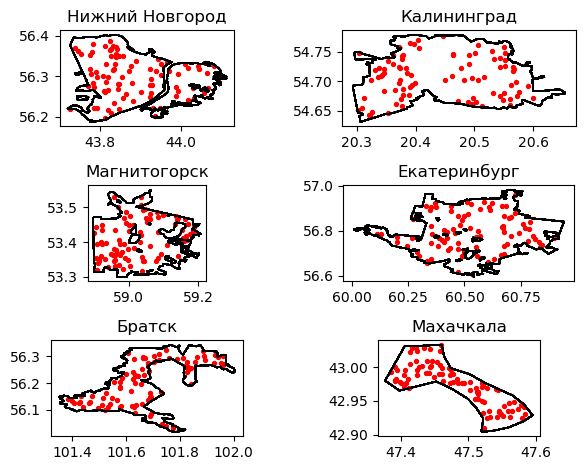

In [336]:
fig, axes = plt.subplots(nrows=3, ncols=2)
six_random_cities_names = [['Нижний Новгород', 'Калининград'], ['Магнитогорск', 'Екатеринбург'], ['Братск', 'Махачкала']]

# all_geoms = gpd.GeoSeries(six_random_cities_check.geometry)
# minx, miny, maxx, maxy = all_geoms.total_bounds

for row, two_cities in zip(axes, six_random_cities_names):
    for ax, city in zip(row, two_cities):
        gpd.GeoSeries(six_random_cities_check.query("area == @city").geometry).boundary.plot(linewidth=1, edgecolor="black", ax=ax)
        gpd.GeoSeries(six_random_cities_check.query("area == @city").merchant_loc).plot(ax=ax, linewidth=1, color="red", markersize=8)
        ax.set_title(city)
        # ax.set_xlim(minx, maxx)
        # ax.set_ylim(miny, maxy)
plt.tight_layout()
plt.show()

In [338]:

clients.head()

,client_id,district_id,birth_date,sex
0,1,18,1970-12-13,female
1,2,1,1945-02-04,male
2,3,1,1940-10-09,female
3,4,5,1956-12-01,male
4,5,5,1960-07-03,female


# Генерация ip-адресов для клиентов
Понадобится для онлайн покупок и, возможно, переводов

In [342]:
clients_and_geo = clients.merge(district_ru, left_on="district_id", right_on="district_code").drop(columns=["district_code", "clients"])
clients_and_geo.head()

,client_id,district_id,birth_date,sex,region,area,timezone,lat,lon,population
0,1,18,1970-12-13,female,Рязанская,Рязань,UTC+3,54.625,39.736,525062
1,2,1,1945-02-04,male,Москва,Москва,UTC+3,55.754,37.620,11514330
2,3,1,1940-10-09,female,Москва,Москва,UTC+3,55.754,37.620,11514330
3,4,5,1956-12-01,male,Ростовская,Ростов-на-Дону,UTC+3,47.222,39.719,1091544
4,5,5,1960-07-03,female,Ростовская,Ростов-на-Дону,UTC+3,47.222,39.719,1091544


In [345]:
ru_77_cities_series = pd.Series(clients_and_geo.area.unique())
ru_77_cities_series

0               Рязань
1               Москва
2       Ростов-на-Дону
3         Петрозаводск
4            Ульяновск
            ...       
72         Стерлитамак
73    Набережные Челны
74           Астрахань
75            Владимир
76         Новокузнецк
Length: 77, dtype: object

In [431]:
ru_ip_ranges = pd.read_csv("./data/raw_data/geo/Russia_and_Belarus_IP_ranges", header=None)

In [432]:
ru_ip_ranges.columns = ["range"]

In [433]:
ru_ip_ranges["range"] = ru_ip_ranges["range"].str.strip()

In [434]:
ru_ip_ranges.shape

(22508, 1)

In [435]:
ru_ip_ranges.head()

,range
0,2.60.0.0/19
1,2.60.32.0/19
2,2.60.64.0/19
3,2.60.96.0/19
4,2.60.128.0/19


In [446]:
ru_ip_ranges_50 = ru_ip_ranges[:50].copy()
ru_ip_ranges_50.shape

(50, 2)

In [447]:
# создадим группы на основании первых двух цифр айпи, чтобы потом взять определенной количество диапазонов из всего датасета

# ru_ip_ranges["first_digit"] = ru_ip_ranges.range.str.split(".").str[:2].str.join(".")
# ru_ip_ranges = ru_ip_ranges[["first_digit", "range"]]
# ru_ip_ranges.head()

In [448]:
# ru_ip_first_ranges = ru_ip_ranges.groupby("first_digit", as_index=False).head(1).reset_index(drop=True)
# ru_ip_first_ranges.head()

In [438]:
# ru_ip_first_ranges.shape

(2162, 2)

In [449]:
# ru_ip_first_ranges.first_digit.str.split(".").str[0].nunique()

In [439]:
# for range in ru_ip_ranges.head().values:
#     print(range[0], "0000")

In [468]:
def get_ips_from_range(ip_range):
    unpacked_ips = []
    # Создаём объект сети
    network = ipaddress.ip_network(ip_range)
    
    # Вывод всех хостов в сети (исключая сетевой и broadcast-адрес)
    for ip in network.hosts():
        unpacked_ips.append(str(ip))
    return pd.Series(unpacked_ips)

In [552]:
# unpacked_ips_glob = []
# unpacked_ips_glob + (ru_ip_ranges_50.range.apply(get_ips_from_range))
unpacked_ips_glob = pd.concat([get_ips_from_range(ip_range) for ip_range in ru_ip_ranges_50.range.values], ignore_index=True)
unpacked_ips_glob.nunique()

606876

In [554]:
unpacked_ips_glob.tail()

606871    5.8.31.250
606872    5.8.31.251
606873    5.8.31.252
606874    5.8.31.253
606875    5.8.31.254
dtype: object

## Присвоение ip клиентам и потенциальным мошенникам

In [474]:
clients_with_geo.head()

,client_id,district_id,birth_date,sex,district_code,region,area,timezone,lat,lon,population,clients,geometry
0,1,18,1970-12-13,female,18,Рязанская,Рязань,UTC+3,54.625,39.736,525062,60,"POLYGON ((39.53667 54.6385, 39.53677 54.63889,..."
1,2,1,1945-02-04,male,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
2,3,1,1940-10-09,female,1,Москва,Москва,UTC+3,55.754,37.620,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55...."
3,4,5,1956-12-01,male,5,Ростовская,Ростов-на-Дону,UTC+3,47.222,39.719,1091544,71,"POLYGON ((39.47099 47.20487, 39.48381 47.22205..."
4,5,5,1960-07-03,female,5,Ростовская,Ростов-на-Дону,UTC+3,47.222,39.719,1091544,71,"POLYGON ((39.47099 47.20487, 39.48381 47.22205..."


In [442]:
# pd.concat([ru_ip_first_ranges.range.apply(get_ips_from_range)], ignore_index=True)

In [477]:
clients_rows = clients_with_geo.shape[0]
clients_rows

5369

In [555]:
clients_with_geo["home_ip"] = unpacked_ips_glob[:clients_rows].copy()
clients_with_geo.head()

,client_id,district_id,birth_date,sex,district_code,region,area,timezone,lat,lon,population,clients,geometry,home_ip
0,1,18,1970-12-13,female,18,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,60,"POLYGON ((39.53667 54.6385, 39.53677 54.63889,...",2.60.0.1
1,2,1,1945-02-04,male,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",2.60.0.2
2,3,1,1940-10-09,female,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",2.60.0.3
3,4,5,1956-12-01,male,5,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,71,"POLYGON ((39.47099 47.20487, 39.48381 47.22205...",2.60.0.4
4,5,5,1960-07-03,female,5,Ростовская,Ростов-на-Дону,UTC+3,47.222436,39.718787,1091544,71,"POLYGON ((39.47099 47.20487, 39.48381 47.22205...",2.60.0.5


In [556]:
ru_77_cities_series.head()

0            Рязань
1            Москва
2    Ростов-на-Дону
3      Петрозаводск
4         Ульяновск
dtype: object

In [571]:
# умножим количество имеющихся городов в 100 раз для добавления 7700 мошеннических/подозрительных ip адресов

online_fraud_cities = pd.concat([ru_77_cities_series for _ in range(100)], ignore_index=True)
print(online_fraud_cities.shape)
online_fraud_cities.tail()

(7700,)


7695         Стерлитамак
7696    Набережные Челны
7697           Астрахань
7698            Владимир
7699         Новокузнецк
dtype: object

In [572]:
# возьмем 7700 ip с конца серии. home ip клиентов мы сзяли с начала серии. Серия очень большая: 600+ тыс адресов
fraud_ip_ser = unpacked_ips_glob.iloc[np.r_[-online_fraud_cities.shape[0]:0]].reset_index(drop=True)
fraud_ip_ser

0       5.3.252.223
1       5.3.252.224
2       5.3.252.225
3       5.3.252.226
4       5.3.252.227
           ...     
7695     5.8.31.250
7696     5.8.31.251
7697     5.8.31.252
7698     5.8.31.253
7699     5.8.31.254
Length: 7700, dtype: object

In [574]:
# соединим названия городов и ip адреса

fraud_ips = pd.concat([online_fraud_cities, fraud_ip_ser], axis=1)
fraud_ips.columns = ["area", "fraud_ip"]
print(fraud_ips.shape)
fraud_ips.tail()

(7700, 2)


,area,fraud_ip
7695,Стерлитамак,5.8.31.250
7696,Набережные Челны,5.8.31.251
7697,Астрахань,5.8.31.252
7698,Владимир,5.8.31.253
7699,Новокузнецк,5.8.31.254


In [575]:
# cities_for_fraud_trans = ru_cities_short.sort_values("popul_ru_clean", ascending=False).reset_index(drop=True)[:400].copy()
# print(cities_for_fraud_trans.shape[0])
# cities_for_fraud_trans.head()

# Генерация транзакций

In [576]:
import random
from datetime import timedelta

In [640]:
# trans_exp = trans[:1000].copy()
# trans_exp.tail()

In [641]:
# trans_exp["date"] = pd.to_datetime(trans_exp.date)

In [639]:
# leap_year_tx = pd.DataFrame({"trans_id":[88888888], "account_id":[99999999], \
#                              "date": [pd.to_datetime("1996-02-29")], "type":["withdrawal"], \
#                              "operation":["withdrawal in cash"], "amount":[2000], \
#                              "balance":[100000]})

In [628]:
# trans_exp = 
# trans_exp.loc[1000] = leap_year_tx
# trans_exp = pd.concat([trans_exp, leap_year_tx], ignore_index=True)

In [636]:
# trans_exp.drop(index=1000, inplace=True)

In [638]:
# trans_exp["changed_date"] = pd.to_datetime(trans_exp.date.dt.year.add(24).astype(str) \
#                                     + "-" + trans_exp.date.dt.month.astype(str) \
#                                     + "-" + trans_exp.date.dt.day.astype(str))

In [642]:
# trans_exp[["date", "changed_date"]]

In [652]:
# clients_with_card = disp.merge(clients, on="client_id") \
#                         .merge(card, on="disp_id") \
#                         [["client_id", "district_id", "birth_date", "sex", "type_y", "issued"]] \
#                         .rename(columns={"type_y":"card_type"}).copy()

In [663]:
dates = pd.Series(pd.date_range(pd.to_datetime("2017-01-01"), pd.to_datetime("2022-12-31"), freq='min'))

In [665]:
dates.sample(n=1000, replace=True).agg(["min", "max"]) #.to_pydatetime().tolist()

min   2017-01-03 12:12:00
max   2022-12-30 19:32:00
dtype: datetime64[ns]

In [799]:
dates.sample(n=1, replace=True).iloc[0]

Timestamp('2018-11-17 13:08:00')

In [1081]:
# добавим колонку онлайн или не онлайн категория со значениями 1 и 0 соответсвенно

category_stats.loc[category_stats.category.str.contains("net"), "online"] = True
category_stats.loc[~category_stats.category.str.contains("net"), "online"] = False
category_stats.head(6)

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,63.577001,15.828399,56370,False,0.101436
1,grocery_pos,115.885327,51.552330,52553,False,0.094568
2,home,57.995413,48.085281,52345,False,0.094193
3,shopping_pos,76.862457,232.484678,49791,False,0.089597
4,kids_pets,57.506913,48.748482,48692,False,0.087620
5,shopping_net,83.481653,237.219758,41779,True,0.075180


In [1082]:
# добавим долю категории, ее "вес" среди категорий - для определения распростаненности категории

category_stats["share"] = category_stats.cat_count.div(category_stats.cat_count.sum())
category_stats.head()

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,63.577001,15.828399,56370,False,0.101436
1,grocery_pos,115.885327,51.552330,52553,False,0.094568
2,home,57.995413,48.085281,52345,False,0.094193
3,shopping_pos,76.862457,232.484678,49791,False,0.089597
4,kids_pets,57.506913,48.748482,48692,False,0.087620


In [1083]:
category_stats_final = category_stats.copy()

In [1084]:
category_stats_final[["avg_amt","amt_std"]] = category_stats_final[["avg_amt","amt_std"]] * 10
category_stats_final

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,635.770012,158.283987,56370,False,0.101436
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568
2,home,579.954129,480.852810,52345,False,0.094193
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597
4,kids_pets,575.069126,487.484822,48692,False,0.087620
5,shopping_net,834.816532,2372.197581,41779,True,0.075180
6,entertainment,639.848399,642.299347,40104,False,0.072166
7,personal_care,482.330206,494.109413,39327,False,0.070768
8,food_dining,507.779383,484.490535,39268,False,0.070662
9,health_fitness,538.674317,479.652511,36674,False,0.065994


In [735]:
# cat_sample_1000 = category_stats_final.category.sample(1000, replace=True, weights=category_stats_final.share)

In [736]:
# pd.concat([category_stats_final, cat_sample_100.value_counts(normalize=True).reset_index()], axis=1)

# Создал доли категорий. И семплинг в зависимости от доли. Можно встраивать в генератор транзакций

In [1085]:
category_stats_final.sample(1, replace=True, weights=category_stats_final.share)

,category,avg_amt,amt_std,cat_count,online,share
8,food_dining,507.779383,484.490535,39268,False,0.070662


In [795]:
# pd.Series([random.random() for i in range(100)]).agg(["min","max"])

In [754]:
# 100 * 2145 / 520_000

### Найдем долю фрода по категориям из датасета kaggle. Для определения вероятности фрода при генерации транзакций

In [762]:
fraud_trans_count_by_cat = fraud_kaggle.query("is_fraud == 1") \
                                        .groupby("category", as_index=False).agg({"trans_num":"count"}) \
                                        .rename(columns={"trans_num":"fraud_count"})
fraud_trans_count_by_cat.head()

,category,fraud_count
0,entertainment,59
1,food_dining,54
2,gas_transport,154
3,grocery_net,41
4,grocery_pos,485


In [1086]:
cat_stats_full = category_stats_final.merge(fraud_trans_count_by_cat, on="category")
cat_stats_full.head(3)

,category,avg_amt,amt_std,cat_count,online,share,fraud_count
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485
2,home,579.954129,480.852810,52345,False,0.094193,67


In [1087]:
# доля фрода в категории

cat_stats_full["fraud_share"] = cat_stats_full.fraud_count.div(cat_stats_full.cat_count)
cat_stats_full.head()

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335


### Добавим критерий возможности круглосуточной покупки в категории

In [1088]:
cat_stats_full["round_clock_cat"] = False

In [1089]:
round_clock = ['gas_transport', 'grocery_pos','shopping_net', 'food_dining', 'misc_pos', 'misc_net', 'grocery_net']

for category in round_clock:
    cat_stats_full.loc[cat_stats_full.category == category, "round_clock_cat"] = True
cat_stats_full

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock_cat
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229,True
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280,False
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278,False
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335,False
5,shopping_net,834.816532,2372.197581,41779,True,0.075180,506,0.012111,True
6,entertainment,639.848399,642.299347,40104,False,0.072166,59,0.001471,False
7,personal_care,482.330206,494.109413,39327,False,0.070768,70,0.001780,False
8,food_dining,507.779383,484.490535,39268,False,0.070662,54,0.001375,True
9,health_fitness,538.674317,479.652511,36674,False,0.065994,52,0.001418,False


In [740]:
"2017-01-01", "2022-12-31"

('2017-01-01', '2022-12-31')

In [894]:
type(Point(0, 0))

shapely.geometry.point.Point

In [896]:
# transactions = pd.DataFrame(
#             {"client_id": [0],
#             "time": [pd.to_datetime("1899-01-01 00:00:00", format="%Y-%m-%d %H:%M:%S")] ,
#             "amount": [0.0],
#             "type": ["unspecified"],
#             "channel": ["unspecified"],
#             "category": ["unspecified"],
#             "online":[0],
#             "merchant_id":[0],
#             "merchant_loc":[Point(0, 0)],
#             "client_ip":["0.0.0.0"],
#             "ip_location": "Nowhere",
#              "account_to": 777777,
#             "is_fraud": 0})
# transactions

In [930]:
# df = pd.DataFrame({
#     "trans_id": pd.Series(dtype="int64"),
#     "account_id": pd.Series(dtype="int64"),
#     "date": pd.Series(dtype="datetime64[ns]"),
#     "type": pd.Series(dtype="string"),
#     "operation": pd.Series(dtype="string"),
#     "amount": pd.Series(dtype="float64"),
#     "balance": pd.Series(dtype="float64"),
# })

### Создадим пустой датафрейм для записи транзакций в него

In [898]:
transactions = gpd.GeoDataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "time": pd.Series(dtype="datetime64[ns]"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="int64"),
            "merchant_id":pd.Series(dtype="int64"),
            "merchant_loc":pd.Series(dtype="geometry"),
            "client_ip":pd.Series(dtype="string"),
            "ip_location": pd.Series(dtype="string"),
             "account_to": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="int64")})
transactions

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud


### Сгенерируем id для онлайн мерчантов. Просто, чтобы было чем заполнить поле merchant_id для онлайн покупок

In [783]:
offline_merch_max_id = int(selling_points_8_merchants.merchant_id.max())
online_merchant_ids = pd.Series([i for i in range(offline_merch_max_id + 1, offline_merch_max_id + 201)])
online_merchant_ids

0      6777
1      6778
2      6779
3      6780
4      6781
       ... 
195    6972
196    6973
197    6974
198    6975
199    6976
Length: 200, dtype: int64

In [788]:
clients_with_geo.head(2)

,client_id,district_id,birth_date,sex,district_code,region,area,timezone,lat,lon,population,clients,geometry,home_ip
0,1,18,1970-12-13,female,18,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,60,"POLYGON ((39.53667 54.6385, 39.53677 54.63889,...",2.60.0.1
1,2,1,1945-02-04,male,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",2.60.0.2


In [791]:
cat_stats_full.head(1)

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share
0,gas_transport,635.770012,158.283987,56370,0.0,0.101436,154,0.002732


In [792]:
selling_points_8_merchants.head(1)

,district_code,region,area,timezone,lat,lon,population,clients,geometry,category,avg_amt,amt_std,cat_count,merchant_id,merchant_loc
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",kids_pets,575.069126,487.484822,486920,1.0,POINT (37.474316943268114 55.88357347760059)


In [811]:
pd.to_datetime("2025-05-28 15:00:31", format="%Y-%m-%d %H:%M:%S") \
- pd.to_datetime("2025-05-28 14:35:31", format="%Y-%m-%d %H:%M:%S") < pd.Timedelta(1800, unit='s')

True

In [864]:
online_merchant_ids.head(2)

0    6777
1    6778
dtype: int64

In [866]:
selling_points_8_merchants.head(1)

,district_code,region,area,timezone,lat,lon,population,clients,geometry,category,avg_amt,amt_std,cat_count,merchant_id,merchant_loc
0,1,Москва,Москва,UTC+3,55.753879,37.620373,11514330,663,"MULTIPOLYGON (((37.2905 55.80199, 37.29542 55....",kids_pets,575.069126,487.484822,486920,1.0,POINT (37.474316943268114 55.88357347760059)


In [865]:
transactions.head()

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud
0,None,None,None,None,None,None,None,None,None,None,None,None,None


In [879]:
catcat = cat_stats_full.sample(1, replace=True, weights=cat_stats_full.share)

In [883]:
# catcat["category"].loc[0] # <---- ошибка потому что времсто iloc - loc

In [914]:
general_time = pd.Series(pd.date_range(pd.to_datetime("2017-01-01 00:00:00", format="%Y-%m-%d %H:%M:%S"), \
                                       pd.to_datetime("2022-12-31 23:59:59", format="%Y-%m-%d %H:%M:%S"), freq='min'))

In [1090]:
# legit_time = general_time[(general_time.dt.hour >= 6) & (general_time.dt.hour < 22)].reset_index(drop=True)
# legit_time.dt.hour.value_counts()

In [1091]:
# fraud_time = general_time[((general_time.dt.hour < 6) & (general_time.dt.hour >= 0)) \
#                 | (general_time.dt.hour >= 22) & (general_time.dt.hour <= 23)] \
#                 .reset_index(drop=True)
# fraud_time.dt.hour.value_counts()

In [954]:
hours_dist = [round(np.random.normal(12, 3)) for i in range(10000)]
hours_dist = [hour for hour in hours_dist if hour < 24 and hour >= 0]

In [ ]:
for hour in hours_dist:
    if hour +

In [955]:
hours_dist_ser = pd.Series(hours_dist)#.value_counts(normalize=True).sort_index()

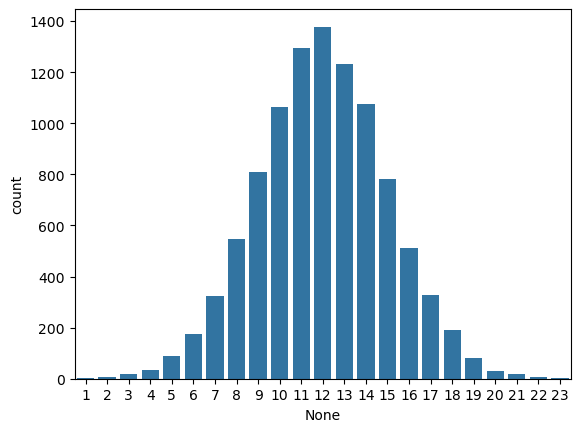

In [956]:
sns.countplot(x=hours_dist_ser);

In [1092]:
# fraud_kaggle["trans_date_trans_time"] = pd.to_datetime(fraud_kaggle.trans_date_trans_time)

In [1093]:
# fraud_kaggle["trans_hour"] = fraud_kaggle["trans_date_trans_time"].dt.hour

In [1094]:
# fraud_kaggle[["trans_date_trans_time", "trans_hour"]].iloc[list(range(0,24000,1000))]

In [1095]:
# legit_kaggle = fraud_kaggle.query("is_fraud == 0")

In [1096]:
# legit_by_cat_and_hour = legit_kaggle.groupby(["trans_hour","category"], as_index=False).agg({"trans_num":"count"}) \
#                                     .rename(columns={"trans_num":"trans_count"})
# legit_by_cat_and_hour.head()

In [1098]:
# legit_kaggle_by_cat = legit_kaggle.groupby(["category"], as_index=False).agg({"trans_num":"count"}) \
#                                     .rename(columns={"trans_num":"total_trans"})
# legit_kaggle_by_cat.head()

In [1099]:
# legit_merge_hour_and_total = legit_by_cat_and_hour.merge(legit_kaggle_by_cat, on="category") \
#                                                 [["category", "trans_hour", "trans_count", "total_trans"]] \
#                                                 .sort_values(["category", "trans_hour"])
# legit_merge_hour_and_total.shape

In [ ]:
# legit_merge_hour_and_total["hour_share"] = legit_merge_hour_and_total.trans_count.div(legit_merge_hour_and_total.total_trans)
# legit_merge_hour_and_total.head()

In [ ]:
# fig, axes = plt.subplots(nrows=cat_stats_full.shape[0], figsize=(10, 60))

# # df = legit_merge_hour_and_total.query("category == 'health_fitness'")
# for ax, category in zip(axes, cat_stats_full["category"]):
#     sns.lineplot(data=legit_merge_hour_and_total.query("category == @category"), x="trans_hour", y="hour_share", ax=ax)
#     ax.set_title(category)
#     ax.set_ylim(0)
# plt.tight_layout()    
# plt.show()

In [ ]:
# df = legit_merge_hour_and_total.query("category == 'grocery_pos'")

# p = sns.barplot(data=df, x="trans_hour", y="trans_count")
# p.set_ylim(0);

In [1190]:
22 * 60 / 340

3.8823529411764706

In [1204]:
(900 - 6 * 60) / 340

1.588235294117647

In [1213]:
(900 - 60 * 6) / 340

1.588235294117647

In [1409]:
16*60

960

# Круглосуточные legit веса - прототип

In [1542]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
mean_morn = 9 * 60
std_morn = 90
morn_start = 6 * 60

# Truncated normal - пик утро
dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
minutes_morn = dist_morn.rvs(3000).astype(int)

# небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
mean_noon = 14 * 60
std_noon= 75
noon_end = 16.5 * 60

# Truncated normal - пик обед
dist_noon = truncnorm((start - mean_noon)/ std_noon, noon_end / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(5000).astype(int)


# Вечерний пик. В районе 19 часов
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 23.3 * 60

# Truncated normal - пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, evn_end / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(9000).astype(int)

# ночная равномерная небольшая активность с 0 до 6:50 утра включительно
night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)

# соединяем все созданные массивы в один
minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

''

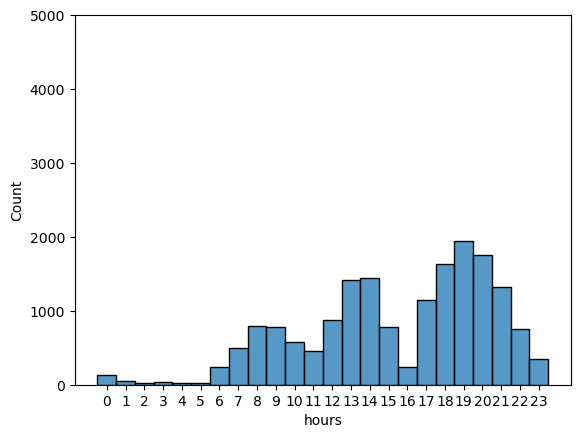

In [1543]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 5000)
;

In [1545]:
17 * 60

1020

# Круглосуточные оффлайн категории - фрод. Прототип

In [1737]:
# равномерная активность с 8 до 23
day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)

# равномерная сниженная активность с 0 до 8
night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)

# соединяем все созданные массивы в один и делаем серией
hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")

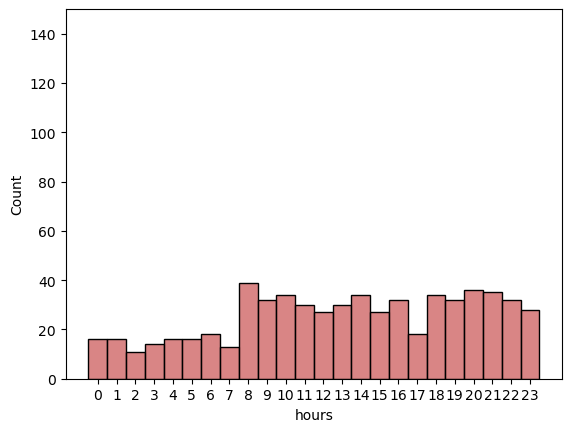

In [1738]:
p = sns.histplot(x=hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=hours.unique())
p.set_ylim(0, 150);

# Онлайн категории, НЕ фрод
	- Пик Вечером после 18. между 18 и 22 включительно

In [1658]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# равномерно с утра до вечера. с 8 до 16 включительно.
day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)


# небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
mean_noon = 14 * 60
std_noon= 75
noon_start = 12 * 60
noon_end = 16.5 * 60

# пик обед
dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(400).astype(int)


# Вечерний пик. От 17 до 23 часов.
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 23.3 * 60

# пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(2000).astype(int)

# ночная равномерная низкая активность с 0 до 7:59 утра
night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)

# соединяем все созданные массивы в один
minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

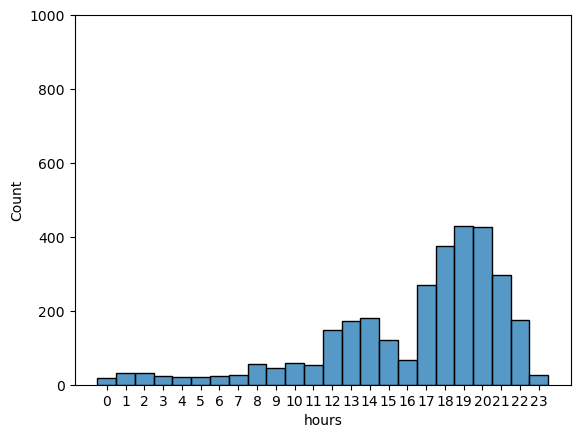

In [1659]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.unique())
p.set_ylim(0, 1000);

# Онлайн фрод - прототип

In [1675]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59


# Ночной пик после 00:00
mean = 1
std = 120

# распределение ночного пика
dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
minutes = dist.rvs(2000).astype(int)

# Добавление веса для вечернего периода (среднее 23:00 - 1140 минут)
mean_evn = 23.9*60
std_evn = 120
evn_end = 23.9*60

# Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(2000).astype(int)

# добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
mid_start = 4 * 60
mid_end = 20.9 * 60
midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)

# соединяем все три массива
total_minutes = np.concatenate((minutes, midday_add, minutes_evn))

times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
time_hours = times.hours

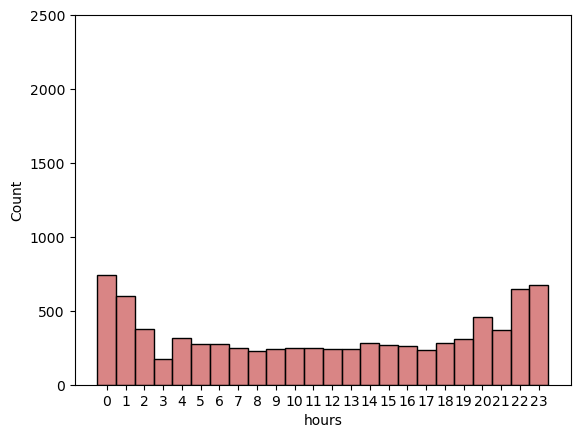

In [1676]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,2500);

# Дневной оффлайн - НЕ фрод. Прототип

In [1720]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# равномерное распределение с 8:00 до 17:00
day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)

# слабый пик обед в районе 13. Интервал с 12 до 17:00
mean_noon = 14 * 60
std_noon= 75
noon_start = 12 * 60
noon_end = 16.5 * 60

# пик обед
dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(1500).astype(int)


# Вечерний пик. С 17:00 до 22:00
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 21.9 * 60

# пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(9000).astype(int)


# соединяем все созданные массивы в один
minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #

# переводим значения массива в тип pd.Timedelta.
# Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
# берем hours оттуда
times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

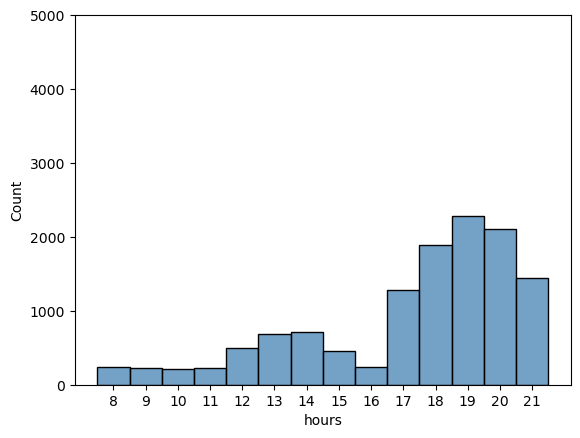

In [1721]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="steelblue")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,5000);

# Дневной оффлайн. Фрод - Прототип

In [1817]:
# равномерная активность с 8:00 до 22:00
day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)

# 
time_hours = pd.Series(day_time, name="hours")

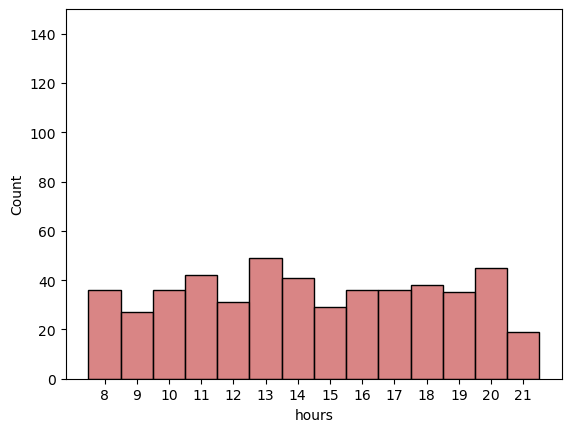

In [1742]:
p = sns.histplot(x=hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=hours.unique())
p.set_ylim(0, 150);

# Функция генерации весов для часов в периоде времени

In [1824]:
def gen_weights_for_time(is_fraud=False, round_clock=False, online=False):
    """
    is_fraud - True или False. По умолчанию False
    round_clock - Круглосуточная категория или нет. True или False. По умолчанию False
    online - None, True или False. По умолчанию False
    """
    # Время в минутах с начала суток. Чтобы ограничить распределения
    start, end = 0, 1439  # 00:00 до 23:59

    #  Далее в зависимости от условий генерация распределения времени для транзакций
    
    # 1. Категория - круглосуточные, оффлайн, НЕ фрод 
    if not is_fraud and round_clock and not online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. 24h. Legit"
        
        # небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
        mean_morn = 9 * 60
        std_morn = 90
        morn_start = 6 * 60
        
        # Truncated normal - пик утро
        dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
        minutes_morn = dist_morn.rvs(3000).astype(int)
        
        # небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
        mean_noon = 14 * 60
        std_noon= 75
        noon_end = 16.5 * 60
        
        # Truncated normal - пик обед
        dist_noon = truncnorm((start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(5000).astype(int)
        
        
        # Вечерний пик. В районе 19 часов
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 23.3 * 60
        
        # Truncated normal - пик вечером
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(9000).astype(int)
        
        # ночная равномерная небольшая активность с 0 до 6:50 утра включительно
        night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

        # переводим значения массива в тип pd.Timedelta.
        # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
        # берем hours оттуда
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours

    # 2. оффлайн фрод. круглосуточные категории
    elif is_fraud and round_clock:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. 24h. Fraud"
        
        # равномерная активность с 8 до 23
        day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)
        
        # равномерная сниженная активность с 0 до 8
        night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)
        
        # соединяем все созданные массивы в один и делаем серией
        time_hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")


    # 3. НЕ фрод. Онлайн покупки
    elif not is_fraud and online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Online. Legit"
        
        # равномерно с утра до вечера. с 8:00 до 16:59
        day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)
        
        
        # небольшой пик обед в районе 13. Обрезанный по 12 и 17 часам
        mean_noon = 14 * 60
        std_noon= 75
        noon_start = 12 * 60
        noon_end = 16.5 * 60
        
        # пик обед. Распределение
        dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(400).astype(int)
        
        
        # Вечерний пик. От 17 до 23 часов.
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 23.3 * 60
        
        # пик вечером. Распределение
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(2000).astype(int)
        
        # ночная равномерная низкая активность с 0 до 7:59 утра
        night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  
        
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours
        
    # 4. онлайн фрод
    elif is_fraud and online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Online. Fraud"
        
        # Ночной пик после 00:00
        mean = 1
        std = 120
        
        # распределение ночного пика
        dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
        minutes = dist.rvs(2000).astype(int)
        
        # Добавление веса для вечернего периода (среднее 23:00 - 1140 минут)
        mean_evn = 23.9*60
        std_evn = 120
        evn_end = 23.9*60
        
        # Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
        dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(2000).astype(int)
        
        # добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
        mid_start = 4 * 60
        mid_end = 20.9 * 60
        midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)
        
        # соединяем все три массива
        total_minutes = np.concatenate((minutes, midday_add, minutes_evn))
        
        times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
        time_hours = times.hours

    # 5. Оффлайн. Не круглосуточный. Не фрод
    elif not is_fraud and not round_clock:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. Day-only. Legit"
        
        # равномерное распределение с 8:00 до 17:00
        day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)
        
        # слабый пик обед в районе 13. Интервал с 12 до 17:00
        mean_noon = 14 * 60
        std_noon= 75
        noon_start = 12 * 60
        noon_end = 16.5 * 60
        
        # пик обед
        dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(1000).astype(int)
        
        
        # Вечерний пик. С 17:00 до 22:00
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 21.9 * 60
        
        # пик вечером
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(9000).astype(int)
        
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #
        
        # переводим значения массива в тип pd.Timedelta.
        # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
        # берем hours оттуда
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours

    # 6. Оффлайн. Не круглосуточный. Фрод
    elif is_fraud and not round_clock:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. Day-only. Fraud"

        # равномерная активность с 8:00 до 22:00
        day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)
        
        # переведем массив в серию
        time_hours = pd.Series(day_time, name="hours")
        
    # if not round_clock:
    #     time_hours

        
    # посчитаем долю каждого часа. Это и будут веса 
    # т.е. вероятность транзакций в этот час для выбранного временного паттерна
    # переведем индекс в колонку т.к. в индексе у нас часы
    hour_weights = time_hours.value_counts(normalize=True).sort_index().reset_index()

    # если период не круглосуточный. То добавить колонку остальных часов со значениями 0, для построения графиков
    if not round_clock:
        all_hours = pd.DataFrame({"hours":np.arange(0,24, step=1)}).astype(int)
        hour_weights = all_hours.merge(hour_weights, how="left", on="hours").fillna(0)
        
    # цвет для графика.
    if not is_fraud:
        color = "steelblue"
    elif is_fraud:
        color = "indianred"
        
    return hour_weights, title, color

# Тест функции gen_weights_for_time(is_fraud=False, round_clock=False, online=False)

In [1823]:
# hour_weights, _, _ = gen_weights_for_time(is_fraud=True, round_clock=False, online=False)

In [1809]:
def plot_time_weights(weights, title, color, ax):
    sns.barplot(x=weights.hours, y=weights.proportion, color=color, ax=ax)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(ticks=np.arange(0, 24, step=1))
    ax.set_ylim(0, 0.4)
    ax.grid(axis="y")
    ax.set_title(title)

In [1843]:
time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

In [1799]:
test_weights, title, color = gen_weights_for_time(**time_weight_args["Offline_24h_Legit"])
plot_time_weights(test_weights, title, color)

TypeError: plot_time_weights() missing 1 required positional argument: 'ax'

# Графики каждого из распределений весов времени

In [1826]:
# time_weights_all = []

# for preset in time_weight_args.keys():
#     weights, title, color = gen_weights_for_time(**time_weight_args[preset])
#     time_weights_all.append([weights, title, color])

In [1828]:
def plot_time_weights(weights, title, color, ax):
    sns.barplot(x=weights.hours, y=weights.proportion, color=color, ax=ax)
    ax.set_xlim(-0.5, 23.5)
    # ax.set_xticks(ticks=np.arange(0, 24, step=1))
    ax.set_ylim(0, 0.4)
    ax.grid(axis="y")
    ax.set_title(title)

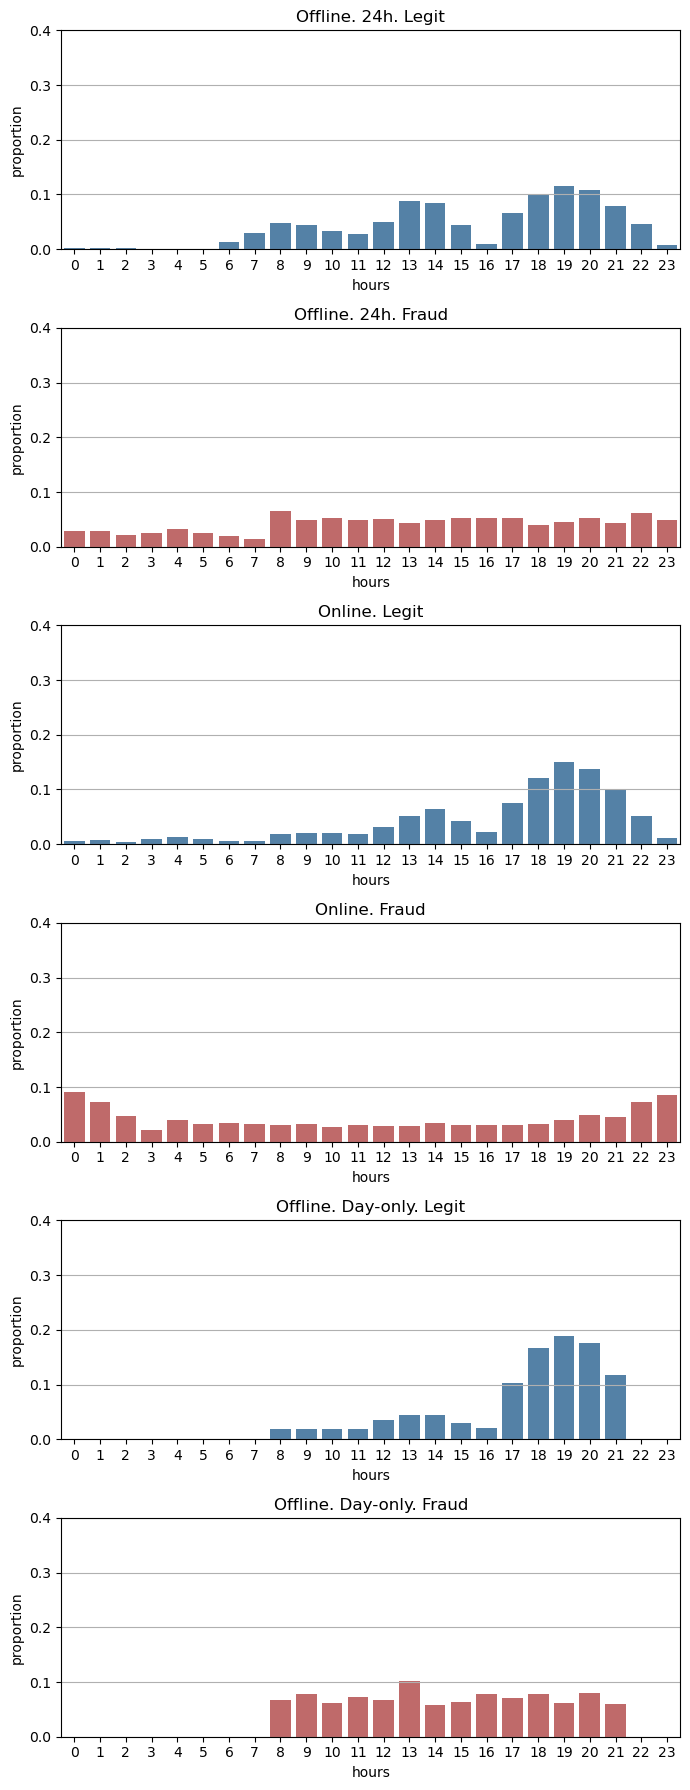

In [1829]:
fig, axes = plt.subplots(nrows=6, figsize=(7, 6*3))

for ax, weight_args_key in zip(axes, time_weight_args.keys()):
    weights, title, color = gen_weights_for_time(**time_weight_args[weight_args_key])
    plot_time_weights(weights, title, color, ax)

plt.tight_layout()
plt.show()    
# list(zip(axes, time_weights_all))

In [1835]:
time_weight_args.keys()

dict_keys(['Offline_24h_Legit', 'Offline_24h_Fraud', 'Online_Legit', 'Online_Fraud', 'Offline_Day_Legit', 'Offline_Day_Fraud'])

In [1845]:
# time_weight_args = {
#                         "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
#                         "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
#                         "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
#                         "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
#                         "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
#                         "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
#                         }

# Проверка функции gen_weights_for_time на генерацию пустых значений

In [1892]:


# словарь для подсчета распределений в которых были пустые значения
empt = defaultdict(int)

# итерирование через варианты распределений
for preset in time_weight_args.keys():
    i = 0
    
    round_clock =  time_weight_args[preset]["round_clock"]

    # создать каждое распределение 100 раз
    while i < 100:
        weights, _, _ = gen_weights_for_time(**time_weight_args[preset])
        
        # если круглосуточное распределение и меньше 24 записей
        if round_clock and weights.shape[0] < 24:
            empt[preset] += 1
            
        # если чисто дневное распределение и меньше 14 записей (22 - 8)
        elif not round_clock and weights[weights.proportion != 0].shape[0] < (22 - 8):
            empt[preset] += 1
        

        # if round_clock:
        #     print(f"{preset} - {weights.shape[0]}")
        # elif not round_clock:
        #     print(f"{preset} - {weights[weights.proportion != 0].shape[0]}")

        i += 1
if empt:
    raise ValueError(f"Some time distributions may generate 0 values. {empt}")
else:
    print("No empty values generated in distributions")

No empty values generated in distributions


# В этой функции именно что select - сэмплирование. А в функции наверху - генерация массива весов для семплирования
Мб  потом джоин весов к периодам

In [1110]:
def select_weights_for_time(is_fraud, round_clock, online):
    """
    генерация весов 
    round_clock - круглые сутки или нет. True или False соотвественно
    is_fraud - фрод или нет. True или False соотвественно
    """

    # Генерация


    
    if round_clock and not is_fraud:
        

_IncompleteInputError: incomplete input (1466952943.py, line 9)

# Основная функция генератор транзакций

In [1297]:
# Генерация POS транзакций
def generate_pos_transactions(client_info, start_date, end_date, categories, fraud_ips, trans_df, merchants_df \
                              ,online_merchant_ids, num=50, fraud_rate=0.05):
    """
    client_info  - датафрейм с данными клиента
    start_date - первая транзакция
    end_date - последняя транзакция
    num - количество транзакций на клиента
    fraud_rate - доля фрода во всех транзакциях
    categories - датафрейм с категориями и их характеристиками
    fraud_ips - датафрейм с фродовыми ip адресами
    trans_df - датафрейм с транзакциями.
               Куда их писать и куда обращаться за информацией по предыдущим транзакциям
    merchants_df - датафрейм с оффлайн мерачантами
    online_merchant_ids - id для онлайн мерчантов
    """
    timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    day_time = timestamps[(timestamps.dt.hour >= 6) & (timestamps.dt.hour < 22)].reset_index(drop=True)
    night_time = timestamps[((timestamps.dt.hour < 6) & (timestamps.dt.hour >= 0)) \
                | (timestamps.dt.hour >= 22) & (timestamps.dt.hour <= 23)] \
                .reset_index(drop=True)

    def get_time_for_trans(trans_df, client_id, round_clock_cat, is_fraud):
        # дата и время последней транзакции клиента
        last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
        
        # если нет предыдущей транзакции
        if last_txn_time is np.nan:
            if round_clock_cat == 1 and not is_fraud:
                txn_time = timestamps.sample(n=1, weights=, replace=True).iloc[0]

            else:
                txn_time = day_time.sample(n=1, replace=True).iloc[0]

        # если есть предыдущая транзакция
        else:
            txn_time = timestamps.sample(n=1, replace=True).iloc[0]
            trans_time_diff = txn_time - last_txn_time
            one_hour_delta = pd.Timedelta(3600, unit="s")

            # если время между текущей и последней транзакцией меньше часа, то добавим время чтобы было час минимум
            if trans_time_diff < one_hour_delta:
                time_addition = one_hour_delta - trans_time_diff
                txn_time = txn_time + time_addition
    
    for lab, row in client_info.iterrows():
        pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

        
        # данные клиента
        client_id = client_info.loc[lab, "client_id"]
        client_area = client_info.loc[lab, "area"]
        client_area_geometry = client_info.loc[lab, "geometry"]
        client_ip = client_info.loc[lab, "home_ip"]

        # цикл создания n транзакций для текущего клиента
        for _ in range(num):
            
                    
            # случайный выбор категории транзакции    
            category = categories.sample(1, replace=True, weights=categories.share)
            category_name = category["category"].iloc[0]
            round_clock = category["round_clock_cat"].iloc[0]
            # средняя сумма для этой категории
            amt_mean = category["avg_amt"].iloc[0]
            # стандартное отклонение сумм для этой категории
            amt_std = category["amt_std"].iloc[0]
            # случайно сгенерированная сумма не менее 1
            amount = max(1, np.random.normal(amt_mean, amt_std))

            # будет ли транзакция фродом или нет. 
            is_fraud = random.random() < fraud_rate

            # генерация данных для оффлайн покупок - не фрод
            if category["online"].iloc[0] == 0 and not is_fraud:
                merchant = merchants_df.loc[(merchants_df.area == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
                merchant_id = merchant["merchant_id"].iloc[0]
                merchant_loc = merchant["merchant_loc"].iloc[0]
                
                pos_txns.append({
                "client_id": client_id, "time": txn_time, "amount": round(amount, 2), "type": "purchase",
                "channel": "POS", "category": category_name, "online": category["online"].iloc[0],
                "merchant_id": merchant_id, "merchant_loc": merchant_loc, "is_fraud": is_fraud
            })

            trans_df_one_client = pd.DataFrame(pos_txns)
        trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

    return trans_df

SyntaxError: expected argument value expression (2438120794.py, line 31)

In [ ]:
client_subset = clients_with_geo.query("client_id == 1")

In [ ]:
client_subset

In [ ]:
trans_for_test = transactions.copy()
trans_for_test

In [ ]:
trans_gen_test_01 = generate_pos_transactions(client_info=client_subset, start_date="2017-01-01", end_date="2022-12-31", num=5, fraud_rate=0.05, \
                              categories=cat_stats_full, fraud_ips=fraud_ips, trans_df=trans_for_test, \
                              merchants_df = selling_points_8_merchants, online_merchant_ids=online_merchant_ids)

In [ ]:
trans_gen_test_01.sort_values("time")

In [1038]:
legit_merge_hour_and_total = legit_by_cat_and_hour.merge(legit_kaggle_by_cat, on="category") \
                                                [["category", "trans_hour", "trans_count", "total_trans"]] \
                                                .sort_values(["category", "trans_hour"])
legit_merge_hour_and_total.shape

In [1039]:
# legit_merge_hour_and_total["hour_share"] = legit_merge_hour_and_total.trans_count.div(legit_merge_hour_and_total.total_trans)
# legit_merge_hour_and_total.head()

In [1037]:
# fig, axes = plt.subplots(nrows=cat_stats_full.shape[0], figsize=(10, 60))

# # df = legit_merge_hour_and_total.query("category == 'health_fitness'")
# for ax, category in zip(axes, cat_stats_full["category"]):
#     sns.lineplot(data=legit_merge_hour_and_total.query("category == @category"), x="trans_hour", y="hour_share", ax=ax)
#     ax.set_title(category)
#     ax.set_ylim(0)
# plt.tight_layout()    
# plt.show()

In [1026]:
# df = legit_merge_hour_and_total.query("category == 'grocery_pos'")

# p = sns.barplot(data=df, x="trans_hour", y="trans_count")
# p.set_ylim(0);

In [1040]:
from scipy.stats import truncnorm

In [1054]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# Пример: сдвиг к дневным часам (12:00 — 720 минут)
mean = 900
std = 180

# Truncated normal для ограничения в рамках суток
dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
minutes = dist.rvs(10000).astype(int)

In [1055]:
times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
# time_objects = [datetime.time(h, m) for h, m in zip(times.hours, times.minutes)]
time_hours = [h for h in times.hours]

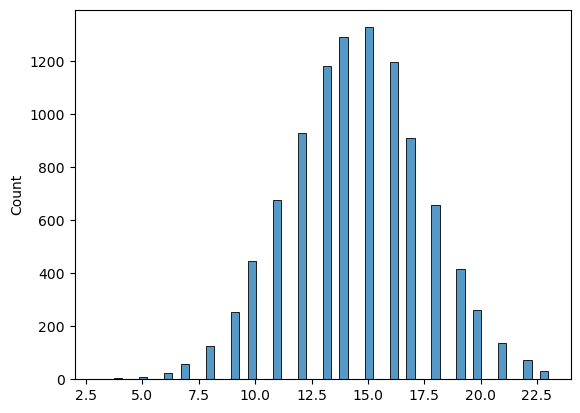

In [1056]:
sns.histplot(x=time_hours);

In [1057]:
day_times = pd.Series(pd.date_range("06:00", "22:00", freq="1min").time)
weights = np.linspace(1, 2, len(day_times))  # например: активность ближе к полудню
chosen = day_times.sample(n=1000, weights=weights, replace=True)

In [1072]:
day_times = pd.Series(pd.date_range("06:00", "22:00", freq="1min"))
day_times_h = day_times.dt.hour
weights = np.linspace(1, 2, len(day_times))  # например: активность ближе к полудню
chosen = day_times_h.sample(n=1000, weights=weights, replace=True)

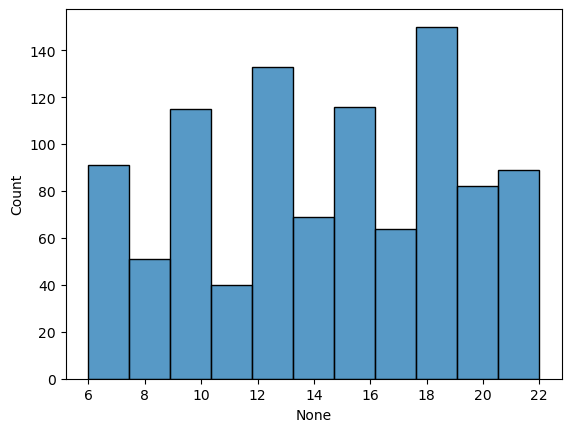

In [1074]:
sns.histplot(x=chosen);

In [1075]:
from scipy.stats import norm

In [1077]:

times = pd.date_range("00:00", "23:59", freq="1min")
minutes = np.arange(len(times))
norm.pdf(minutes, loc=2 * 60, scale=30)

array([0.00000446, 0.00000509, 0.00000581, ..., 0.        , 0.        ,
       0.        ], shape=(1440,))

In [ ]:
def get_weights_for_time(round_clock, is_fraud):
    """
    round_clock - круглые сутки или нет. 1 или 0 соотвественно
    is_fraud - фрод или нет. True или False соотвественно
    """

    if round_clock == 1 and is_fraud

In [909]:
# Генерация POS транзакций
def generate_pos_transactions(client_info, start_date, end_date, categories, fraud_ips, trans_df, merchants_df \
                              ,online_merchant_ids, num=50, fraud_rate=0.05):
    """
    client_info  - датафрейм с данными клиента
    start_date - первая транзакция
    end_date - последняя транзакция
    num - количество транзакций на клиента
    fraud_rate - доля фрода во всех транзакциях
    categories - датафрейм с категориями и их характеристиками
    fraud_ips - датафрейм с фродовыми ip адресами
    trans_df - датафрейм с транзакциями.
               Куда их писать и куда обращаться за информацией по предыдущим транзакциям
    merchants_df - датафрейм с оффлайн мерачантами
    online_merchant_ids - id для онлайн мерчантов
    """
    timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    day_time = timestamps[(timestamps.dt.hour >= 6) & (timestamps.dt.hour < 22)].reset_index(drop=True)
    night_time = timestamps[((timestamps.dt.hour < 6) & (timestamps.dt.hour >= 0)) \
                | (timestamps.dt.hour >= 22) & (timestamps.dt.hour <= 23)] \
                .reset_index(drop=True)

    def get_time_for_trans(trans_df, client_id, round_clock_cat, is_fraud):
        # дата и время последней транзакции клиента
        last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
        
        # если нет предыдущей транзакции
        if last_txn_time is np.nan:
            if round_clock_cat == 1 and not is_fraud:
                txn_time = timestamps.sample(n=1, weights=, replace=True).iloc[0]

            else:
                txn_time = day_time.sample(n=1, replace=True).iloc[0]

        # если есть предыдущая транзакция
        else:
            txn_time = timestamps.sample(n=1, replace=True).iloc[0]
            trans_time_diff = txn_time - last_txn_time
            one_hour_delta = pd.Timedelta(3600, unit="s")

            # если время между текущей и последней транзакцией меньше часа, то добавим время чтобы было час минимум
            if trans_time_diff < one_hour_delta:
                time_addition = one_hour_delta - trans_time_diff
                txn_time = txn_time + time_addition
    
    for lab, row in client_info.iterrows():
        pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

        
        # данные клиента
        client_id = client_info.loc[lab, "client_id"]
        client_area = client_info.loc[lab, "area"]
        client_area_geometry = client_info.loc[lab, "geometry"]
        client_ip = client_info.loc[lab, "home_ip"]

        # цикл создания n транзакций для текущего клиента
        for _ in range(num):
            
                    
            # случайный выбор категории транзакции    
            category = categories.sample(1, replace=True, weights=categories.share)
            category_name = category["category"].iloc[0]
            round_clock = category["round_clock_cat"].iloc[0]
            # средняя сумма для этой категории
            amt_mean = category["avg_amt"].iloc[0]
            # стандартное отклонение сумм для этой категории
            amt_std = category["amt_std"].iloc[0]
            # случайно сгенерированная сумма не менее 1
            amount = max(1, np.random.normal(amt_mean, amt_std))

            # будет ли транзакция фродом или нет. 
            is_fraud = random.random() < fraud_rate

            # генерация данных для оффлайн покупок - не фрод
            if category["online"].iloc[0] == 0 and not is_fraud:
                merchant = merchants_df.loc[(merchants_df.area == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
                merchant_id = merchant["merchant_id"].iloc[0]
                merchant_loc = merchant["merchant_loc"].iloc[0]
                
                pos_txns.append({
                "client_id": client_id, "time": txn_time, "amount": round(amount, 2), "type": "purchase",
                "channel": "POS", "category": category_name, "online": category["online"].iloc[0],
                "merchant_id": merchant_id, "merchant_loc": merchant_loc, "is_fraud": is_fraud
            })

            trans_df_one_client = pd.DataFrame(pos_txns)
        trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

    return trans_df

In [872]:
client_subset = clients_with_geo.query("client_id == 1")

In [907]:
client_subset

,client_id,district_id,birth_date,sex,district_code,region,area,timezone,lat,lon,population,clients,geometry,home_ip
0,1,18,1970-12-13,female,18,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,60,"POLYGON ((39.53667 54.6385, 39.53677 54.63889,...",2.60.0.1


In [910]:
trans_for_test = transactions.copy()
trans_for_test

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud


In [911]:
trans_gen_test_01 = generate_pos_transactions(client_info=client_subset, start_date="2017-01-01", end_date="2022-12-31", num=5, fraud_rate=0.05, \
                              categories=cat_stats_full, fraud_ips=fraud_ips, trans_df=trans_for_test, \
                              merchants_df = selling_points_8_merchants, online_merchant_ids=online_merchant_ids)

In [912]:
trans_gen_test_01.sort_values("time")

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud
0,1,2020-06-17 15:32:00,388.33,purchase,POS,misc_pos,0.0,2876.0,POINT (39.58864244042683 54.64360405430491),<NA>,<NA>,NaN,0
1,1,2021-07-04 23:52:00,539.23,purchase,POS,personal_care,0.0,3729.0,POINT (39.74591808527166 54.637572015694126),<NA>,<NA>,NaN,0
2,1,2021-11-30 08:10:00,105.37,purchase,POS,kids_pets,0.0,6262.0,POINT (39.79949759003459 54.60411155098016),<NA>,<NA>,NaN,0


In [ ]:
# amounts = []
# category = cat_stats_full.sample(1, replace=True, weights=cat_stats_full.share)
# for _ in range(100):

    
#     amt_mean = category["avg_amt"].iloc[0]
#     amt_std = category["amt_std"].iloc[0]
#     amount = max(1, np.random.normal(amt_mean, amt_std))

#     amounts.append(amount)
#     # print(f"""
#     # Category: {category["category"]}
#     # Amount: {amount}
#     # """)

# print(f"""Category: {category["category"]}""")
# pd.Series(amounts).mean()

In [ ]:
# cat_stats_full.query("category == @category['category'].iloc[0]")

### Часть от оригинальной функции от GPT

In [908]:
                
            # генерация данных для онлайн покупок: ip
            # if category["online"] == 1:
                
            # Гео — нормальный город
            # city = random.choice(list(city_coords.keys()))
            # lat, lon = city_coords[city]
            # lat += np.random.normal(0, 0.01)
            # lon += np.random.normal(0, 0.01)
    
            
            # if is_fraud:
            #     # Фрод: другой город, высокая сумма, необычная категория
            #     category = "luxury"
            #     amount = np.random.uniform(20000, 150000)
            #     lat += np.random.normal(5, 2)  # далеко
            #     lon += np.random.normal(5, 2)
    
            # pos_txns.append({
            #     "client_id": client_id,
            #     "date": txn_date,
            #     "amount": round(amount, 2),
            #     "type": "purchase",
            #     "channel": "POS",
            #     "category": category,
            #     "latitude": lat,
            #     "longitude": lon,
            #     "is_fraud": is_fraud
            # })

    # return pd.DataFrame(pos_txns)

# Внизу образец генерации транзакций от GPT

In [ ]:
import random
from datetime import timedelta

# Категории и примерные средние суммы (можно расширить)
categories = {
    "grocery": (300, 100),
    "electronics": (10000, 5000),
    "transport": (150, 50),
    "restaurants": (800, 200),
    "clothing": (2000, 800)
}

# Список городов с координатами
city_coords = {
    "Москва": (55.75, 37.62),
    "Санкт-Петербург": (59.94, 30.31),
    "Казань": (55.79, 49.12),
    "Екатеринбург": (56.84, 60.61)
}

In [ ]:
# Генерация POS транзакций
def generate_pos_transactions(account_id, client_id, start_date, end_date, num=50, fraud_rate=0.05):
    dates = pd.date_range(start_date, end_date, freq='D').to_pydatetime().tolist()
    pos_txns = []

    for _ in range(num):
        txn_date = random.choice(dates)
        category = random.choice(list(categories.keys()))
        mean, std = categories[category]
        amount = max(1, np.random.normal(mean, std))

        # Гео — нормальный город
        city = random.choice(list(city_coords.keys()))
        lat, lon = city_coords[city]
        lat += np.random.normal(0, 0.01)
        lon += np.random.normal(0, 0.01)

        is_fraud = random.random() < fraud_rate
        if is_fraud:
            # Фрод: другой город, высокая сумма, необычная категория
            category = "luxury"
            amount = np.random.uniform(20000, 150000)
            lat += np.random.normal(5, 2)  # далеко
            lon += np.random.normal(5, 2)

        pos_txns.append({
            "account_id": account_id,
            "client_id": client_id,
            "date": txn_date,
            "amount": round(amount, 2),
            "type": "purchase",
            "channel": "POS",
            "category": category,
            "latitude": lat,
            "longitude": lon,
            "is_fraud": is_fraud
        })

    return pd.DataFrame(pos_txns)

## Нормальное распределение

In [707]:
# 56.310481, 43.989214

In [708]:
# 56.335365, 43.922722 # std


In [709]:
# 56.335365 - 56.304909

In [710]:
# 43.989214 - 43.922722

In [711]:
# from shapely.geometry import Point, Polygon

# def Random_Points_in_Bounds_Normal(polygon, number, mean_x, mean_y, std_x, std_y):   
    
#     x = np.random.normal(mean_x, std_x, number)
#     y = np.random.normal(mean_y, std_y, number)
#     return x, y

In [712]:
# nn_poly = district_ru_merge.query("area == 'Нижний Новгород'").iloc[0,-1]

In [713]:
# gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[nn_poly])
# gdf_poly

In [714]:
# x,y = Random_Points_in_Bounds_Normal(nn_poly, 1000, mean_x=43.989214, mean_y= 56.310481, std_x=0.066491999, std_y=0.030456)
# df = pd.DataFrame()
# df['points'] = list(zip(x,y))
# df['points'] = df['points'].apply(Point)
# gdf_points = gpd.GeoDataFrame(df, geometry='points')

In [715]:
# Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# # Keep points in "myPoly"
# pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# # Plot result
# base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
# gdf_points.plot(ax=base, linewidth=1, color="red", markersize=8)
# plt.show()

In [716]:
ru_cities_tent_subset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [717]:
from shapely.ops import transform
from pyproj import Geod

# Две координаты: (долгота, широта)
coord1 = (37.6173, 55.7558)   # Москва
coord2 = (65.502079, 44.848393)   # Кызылорда 2300 km

# Геодезический расчёт по эллипсоиду WGS84
geod = Geod(ellps="WGS84")
distance_m = geod.inv(coord1[0], coord1[1], coord2[0], coord2[1])[-1]

print(f"Расстояние: {distance_m / 1000:.2f} км")

Расстояние: 2304.08 км


In [718]:
# files = os.listdir()
# files
# name_part = "10_kalin_ru"

# for file in files:
#     file_split =  file.split(".")
#     if file_split[0] == "gis_osm_places_a_free_1":
#         new_name = name_part + "." + file_split[-1]
#         print(new_name)
#         os.rename(file, new_name)
    # elif file_split[0] == "07_ural_ru":
    #     new_name = name_part + "." + file_split[-1]
    #     print(new_name)
    #     os.rename(file, new_name)
        
# os.rename("test.txt", "renamed")
# "asdasd.shp".split(".")[-1]

In [719]:
# os.chdir("./data/raw_data/geo/")

In [720]:
# gpd.read_file("data/raw_data/geo/01_central_ru.shp")

In [721]:
# # ru_city_shapes = 
# pd.concat([gpd.read_file(f"./data/raw_data/geo/{file}").query("fclass == 'city'") for file in geo_files])

In [722]:
# os.chdir("C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\")